In [1]:
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload

## Load external data

In [2]:
freq = 'w'
risk_profile = 3
current_date = '2020-03-10'

#### Prices

In [3]:
filepath = '../../data/external/'
filename = 'price_db_' + freq + '.pkl'
price_db = pd.read_pickle(filepath+filename)

Make `df_price`, a matrix of log returns of all eligible **instruments** in the universe with:
- Columns: itemcode
- Rows: date

In [4]:
df_price = price_db[price_db.itemtype=='ETF'].pivot(index='date', columns='itemcode', values='price').dropna()
df_price = df_price[df_price.index <= current_date]

In [5]:
df_price.tail(3)

itemcode,A069500,A091160,A091170,A091180,A102110,A102780,A105190,A114260,A122260,A130730,...,A245710,A251350,A266370,A273130,A278540,A283580,A292150,A293180,A302190,A314250
date,,,,,,,,,,,,,,,,,,,,,
2020-02-21,28991.0,27126.0,5974.0,13684.0,28836.0,7271.0,29139.0,57435.0,99890.0,100009.0,...,13365.0,15940.0,14882.0,109555.0,9400.0,10980.0,9487.0,28956.0,52801.0,15915.0
2020-02-28,26622.0,23904.0,5669.0,12577.0,26503.0,6670.0,26790.0,57545.0,99969.0,100073.0,...,12760.0,14140.0,13105.0,110085.0,8635.0,10700.0,8607.0,26648.0,53132.0,13360.0
2020-03-06,27297.0,25328.0,5458.0,12230.0,27175.0,6897.0,27439.0,57650.0,100048.0,100108.0,...,12605.0,14260.0,13854.0,110145.0,8830.0,11075.0,8833.0,27280.0,53078.0,14030.0


## Estimation
- `cov`: A robust estimation of the covariance matrix of `df_price`
- `df_mean`: Historical mean returns

#### We use a Minimum Covariance Determinant (MCD) robust estimator for an estimate that's less sensitive to price outliers.

In [6]:
from sklearn.covariance import MinCovDet
from portfoliolab.estimators import ReturnsEstimators
import matplotlib.pyplot as plt
from portfoliolab.modern_portfolio_theory import MeanVarianceOptimisation

In [7]:
# fit a Minimum Covariance Determinant (MCD) robust estimator to data
mcd = MinCovDet().fit(df_price)
cov = mcd.covariance_

In [8]:
# Calculating our asset returns in order to calculate our covariance matrix
df_rt = ReturnsEstimators.calculate_returns(df_price)
df_mean = ReturnsEstimators.calculate_mean_historical_returns(df_price)

## Optimization

**Note** for the `weights` variable:
The *Portfolio Lab* package internally declares a Python variable - `weights` - for the final portfolio weights. Use this same variable name whenever you want to include it in one of your custom variable declarations.

In [9]:
import cvxpy as cp

#### Specify variables in `non_cvxpy_var` that are not related to a convex optimizer, *cvxpy*.

In [10]:
non_cvxpy_var = {
    'asset_prices': df_price,
    'num_assets': df_price.shape[1],
    'covariance': cov,
    'asset_names': df_price.columns,
    'expected_returns': df_mean
}

#### Specify *cvxpy* variables in `cvxpy_var`.
- For this, we are using non-cvxpy variables, namely, `covariance` and `expected_returns` that we defined just in `non_cvxpy_var`.

In [11]:
cvxpy_var = [
        'risk = cp.quad_form(weights, covariance)',
        'portfolio_return = cp.matmul(weights, expected_returns)'
]

### Apply constraints

#### Load portfolio constraints

In [12]:
import riskfolio.ConstraintsFunctions as cf
import utils

#### Load asset classification and constraints information
- `asset_classes` <- `universe` <- tradable_instruments.pkl left join with instruments_m.pkl
- `constraints` <- constraints.pkl

In [13]:
df_price

itemcode,A069500,A091160,A091170,A091180,A102110,A102780,A105190,A114260,A122260,A130730,...,A245710,A251350,A266370,A273130,A278540,A283580,A292150,A293180,A302190,A314250
date,,,,,,,,,,,,,,,,,,,,,
2019-01-11,25949.0,17381.0,6656.0,13137.0,25797.0,6157.0,26135.0,55730.0,97839.0,98208.0,...,12540.0,11850.0,10852.0,104355.0,8145.0,7880.0,7604.0,25917.0,50484.0,10195.0
2019-01-18,26614.0,17745.0,6904.0,14078.0,26458.0,6293.0,26783.0,55730.0,97853.0,98237.0,...,12515.0,12045.0,10916.0,104365.0,8360.0,8025.0,7786.0,26574.0,50454.0,10490.0
2019-01-25,27356.0,19240.0,6949.0,13905.0,27186.0,6546.0,27565.0,55735.0,97873.0,98266.0,...,12730.0,12100.0,11604.0,104385.0,8630.0,8135.0,8065.0,27317.0,50503.0,10185.0
2019-02-01,27748.0,19830.0,7192.0,14159.0,27567.0,6570.0,27927.0,55780.0,97912.0,98305.0,...,12560.0,12355.0,11786.0,104535.0,8805.0,8245.0,8320.0,27694.0,50532.0,10545.0
2019-02-08,27356.0,19948.0,7201.0,14010.0,27204.0,6527.0,27522.0,55810.0,97950.0,98329.0,...,12605.0,12270.0,11722.0,104630.0,8640.0,8255.0,8089.0,27326.0,50557.0,10440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-07,29530.0,26359.0,6354.0,13952.0,29401.0,7380.0,29662.0,57255.0,99796.0,99939.0,...,13200.0,15825.0,14643.0,108755.0,9530.0,10230.0,9521.0,29514.0,52381.0,14980.0
2020-02-14,30010.0,28072.0,6209.0,14172.0,29859.0,7543.0,30199.0,57190.0,99801.0,99979.0,...,13115.0,15840.0,15254.0,108600.0,9740.0,10460.0,9762.0,29980.0,52179.0,15465.0
2020-02-21,28991.0,27126.0,5974.0,13684.0,28836.0,7271.0,29139.0,57435.0,99890.0,100009.0,...,13365.0,15940.0,14882.0,109555.0,9400.0,10980.0,9487.0,28956.0,52801.0,15915.0


In [14]:
# instruments_m: 투자가능 종목들 목록 (현재 시점의 거래금액, 시총 보고 뽑음)
filepath = '../../data/processed/'
filename = 'instruments_m.pkl'
instruments_m = pd.read_pickle(filepath+filename)

# simulatable_instruments: 상장된 지 3년 넘은 종목 (시뮬레이션을 위해 필요한 요건)
filepath = '../../data/external/'
filename = 'simulatable_instruments.pkl'
simulatable_instruments = pd.read_pickle(filepath+filename)

# 사용자가 지정한 제약조건 테이블. Aw>=B 형식으로 되어 있어 사람이 이해하기 편함.
filepath = '../../data/processed/'
filename = 'constraints.pkl'
df_constraints = pd.read_pickle(filepath+filename)

universe = pd.merge(simulatable_instruments, instruments_m, left_on='itemcode', right_on='itemcode', how='left')

In [15]:
universe = universe.set_index(['itemcode'], drop=True).loc[df_price.columns]
universe = universe.reset_index()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['A302190', 'A314250'], dtype='object', name='itemcode'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

#### Aw>=B 형식의 제약조건을 `riskfolio-lib`가 요구하는 형식으로 변환
- `asset_classes`
- `constraints`

In [ ]:
asset_classes = utils.get_asset_classes(universe)

#### Remove strategy constraints for now.

In [ ]:
# df_constraints = df_constraints.drop(df_constraints[df_constraints.Set=='Strategy'].index)
# df_constraints = df_constraints.drop(df_constraints[df_constraints.Set=='DC risky asset'].index)

In [16]:
constraints = df_constraints[np.logical_or(
    df_constraints.risk_profile == str(risk_profile), df_constraints.risk_profile == 'Common')].drop(['risk_profile'], axis=1)
# constraints.loc[0, 'Type'] = 'Classes'
# constraints.loc[0, 'Weight'] = 0.4
# constraints.loc[0, 'Sign'] = '<='
# constraints.loc[10, 'Weight'] = 0.2
constraints.loc[8, 'Factor'] = 4
constraints.loc[11, 'Sign'] = '<='
constraints.loc[11, 'Weight'] = 0.7
constraints.loc[:, 'Disabled'] = False

In [17]:
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
5,False,Classes,Asset class,Equity,>=,0.40,NaN,NaN,NaN,NaN
6,False,Classes,Asset class,Equity,<=,0.60,NaN,NaN,NaN,NaN
7,False,Classes,Asset class,Fixed Income,<=,0.70,NaN,NaN,NaN,NaN
8,False,Classes,Asset class,Alternative,<=,0.25,NaN,NaN,NaN,4.0
9,False,Assets,NaN,A237370,>=,0.02,NaN,NaN,NaN,NaN
16,False,Classes,Strategy,Core,>=,NaN,Classes,Strategy,Satellite,4.0
18,False,All Assets,NaN,NaN,<=,0.24,NaN,NaN,NaN,NaN
19,False,Classes,DC risky asset,Y,<=,0.70,NaN,NaN,NaN,NaN
11,False,NaN,NaN,NaN,<=,0.70,NaN,NaN,NaN,NaN


#### We have constraints matrice `A` and `B` such that
- $Aw \ge B$.

In [18]:
A, B = cf.assets_constraints(constraints, asset_classes)

NameError: name 'asset_classes' is not defined

In [19]:
def get_custom_constraints(A, B):
    '''
    어떤 선형 제약조건도 Aw>=B로 표현할 수 있다. A, B를 입력으로 받아
    컨벡스 최적화 패키지 cvxpy에서 사용가능한 제약조건 표시형식으로 변환하여 반환한다.
    
    Parameters:
    A - pd.DataFrame
        Shape: (제약조건식의 개수, 투자자산의 개수)
    B - pd.DataFrame
        Shape: (제약조건식의 개수, 1)
    
    Returns:
    custom_constraints - list
        cvxpy 패키지에서 사용가능한 제약조건들
    '''
    custom_constraints = []
    for i, row in enumerate(A):
        constraint = []
        for idx, j in enumerate(row):
            term_in_constraint = '{:f}*weights[{:d}]'.format(j, idx) if j != 0 else None
            constraint.append(term_in_constraint)

        # Remove every None from this list.
        constraint = [c for c in constraint if c is not None]

        # 제약조건 1개는 A[i, :]*B[i]로 만들어짐.
        # 이 제약조건 1개는 a+b+c>=0.1 같은 형식이므로, 이걸 '+'.join으로 연결해서 list 원소 1개를 만든다.
        # A의 row 개수만큼 이 작업을 for-loop 내에서 반복하면 이 작업은 완료된다.
        if constraint:  # 현재 row에 1개라도 non-zero가 있을 때만 custom_constraints에 추가한다.
            custom_constraints.append('+'.join(constraint) + '>=' + str(B[i][0]))
    
    return custom_constraints

In [20]:
cvx_constraints = get_custom_constraints(A, B)
cvx_constraints = ['cp.sum(weights) == 1', 'weights >= 0', 'weights <= 1'] + cvx_constraints

NameError: name 'A' is not defined

In [21]:
cvx_constraints

NameError: name 'cvx_constraints' is not defined

In [22]:
asset_classes

NameError: name 'asset_classes' is not defined

#### Set an objective function

In [23]:
obj = 'cp.Minimize(risk)'

#### Run an optimizer

In [24]:
# wt_bounds=['1.000000*weights[0]+1.000000*weights[1]+1.000000*weights[2]+1.000000*weights[3]+1.000000*weights[4]+1.000000*weights[5]+1.000000*weights[9]+1.000000*weights[10]+1.000000*weights[11]+1.000000*weights[12]+1.000000*weights[13]+1.000000*weights[14]+1.000000*weights[15]+1.000000*weights[16]+1.000000*weights[18]+1.000000*weights[21]+1.000000*weights[23]+1.000000*weights[25]>=0.1']
# wt_bounds=['1.000000*weights[0]+1.000000*weights[1]>=0.8']

In [25]:
port = MeanVarianceOptimisation()
# port.allocate(asset_names=df_price.columns,
#                asset_prices=df_price,
#                solution='min_volatility',
#             weight_bounds=cvx_constraints)
port.allocate_custom_objective(non_cvxpy_variables=non_cvxpy_var,
                               cvxpy_variables=cvxpy_var, objective_function=obj, constraints=cvx_constraints)

NameError: name 'cvx_constraints' is not defined

#### Manipulate `w`, the weight vector to plot portfolio weights.

In [26]:
w = port.weights.T
w.rename(columns={w.columns[0]:'weights'}, inplace=True)
w = pd.merge(w, universe.loc[:,['itemcode', 'tracking_code']], left_index=True, right_on='itemcode', how='left').set_index('itemcode', drop=True)
w = w[['weights', 'tracking_code']]

AttributeError: 'list' object has no attribute 'T'

#### Put small weights (<5%) into one category, namely, others.

In [27]:
small_wt = w[w.weights < 0.05].weights.sum()
w_others = pd.DataFrame.from_dict(
    {'OTHERS': [w[w.weights < 0.05].weights.sum(), 'Others']},
    orient='index',
    columns=w.columns) if small_wt >= 0.005 else None

NameError: name 'w' is not defined

In [28]:
w = pd.concat([w.drop(w[w.weights<0.05].index), w_others])

NameError: name 'w' is not defined

In [29]:
import plotly.express as px
fig = px.pie(w, values='weights', names='tracking_code', title='Portfolio weights',
             labels=dict(zip(w.tracking_code, w.weights)), hole=0.5, width=600,
             color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

NameError: name 'w' is not defined

In [30]:
import plotly.express as px
fig = px.pie(w, values='weights', names='tracking_code', title='Portfolio weights',
             labels=dict(zip(w.tracking_code, w.weights)), hole=0.5, width=600,
             color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

NameError: name 'w' is not defined

In [31]:
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
5,False,Classes,Asset class,Equity,>=,0.40,NaN,NaN,NaN,NaN
6,False,Classes,Asset class,Equity,<=,0.60,NaN,NaN,NaN,NaN
7,False,Classes,Asset class,Fixed Income,<=,0.70,NaN,NaN,NaN,NaN
8,False,Classes,Asset class,Alternative,<=,0.25,NaN,NaN,NaN,4.0
9,False,Assets,NaN,A237370,>=,0.02,NaN,NaN,NaN,NaN
16,False,Classes,Strategy,Core,>=,NaN,Classes,Strategy,Satellite,4.0
18,False,All Assets,NaN,NaN,<=,0.24,NaN,NaN,NaN,NaN
19,False,Classes,DC risky asset,Y,<=,0.70,NaN,NaN,NaN,NaN
11,False,NaN,NaN,NaN,<=,0.70,NaN,NaN,NaN,NaN


In [32]:
import plotly.express as px

In [33]:
def plot_donut(
    data_frame=None,
    names=None,
    values=None,
    color=None,
    color_discrete_sequence=None,
    color_discrete_map=None,
    hover_name=None,
    hover_data=None,
    custom_data=None,
    labels=None,
    title=None,
    template=None,
    width=None,
    height=None,
    opacity=None,
    hole=None,
    others=0.05
):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-33-2a0220ec565d>, line 20)

In [34]:
fig = px.pie(w, values='weights', names='tracking_code', title='Portfolio weights')
fig.show()

NameError: name 'w' is not defined

In [46]:
import riskfolio.PlotFunctions as plf

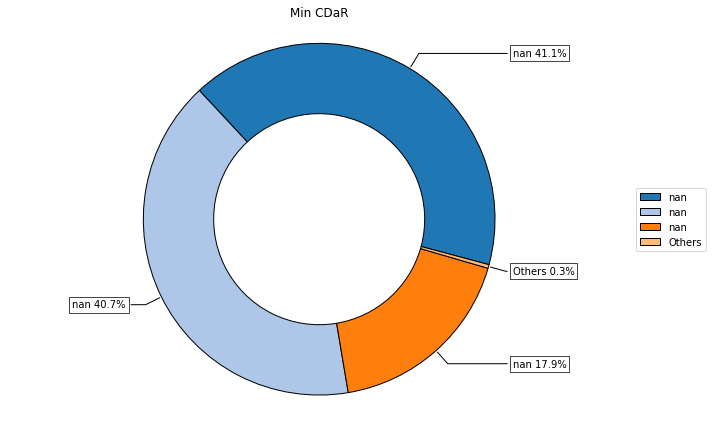

In [47]:
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

## Estimaing mean risk portfolios

- Using ***CDaR*** instead of variance as a risk measure.
  - Conditional Drawdown at Risk(CDaR) is the average drawdown for all the instances that drawdown **exceeded** a certain threshold. Drawdown is a measure of downside risk.
  - https://breakingdownfinance.com/finance-topics/alternative-investments/conditional-drawdown-at-risk-cdar/

In [48]:
import riskfolio.Portfolio as pf
import datetime

`y` is a matrix of log returns of all eligible instruments in the universe.

In [49]:
current_date = '2020-03-10'
y = df_rt[df_rt.index <= current_date]

In [50]:
df_rf = price_db[price_db.itemtype=='riskfree'].set_index('date', drop=True)
current_idx = df_rf.index.asof(datetime.datetime.strptime(current_date, '%Y-%m-%d'))
rf = df_rf.loc[current_idx].price  # risk free rate

#### Set a log-return matrix `y`

In [51]:
port = pf.Portfolio(returns=y) 

#### Set estimating methods
- `method_mu` to estimate expected returns.
- `method_cov` to estimated a covariance matrix.

In [52]:
method_mu='hist'  # Method to estimate expected returns; ewma with adjust=True. See pandas.DataFrame.ewm for more details.
method_cov='hist' # Method to estimate covariance matrix; ewma with adjust=True
decay=0.94

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=decay)

You must convert self.cov to a positive definite matrix


#### Apply constraints

In [53]:
port.ainequality = A
port.binequality = B

NameError: name 'A' is not defined

In [54]:
# Estimate optimal portfolio:
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
l=0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

In [55]:
w

,weights
A069500,7.680175e-14
A091160,2.624274e-03
A091170,1.868952e-12
A091180,6.509769e-14
A102110,7.794014e-14
A102780,4.918204e-14
A105190,9.776004e-14
A114260,4.549009e-13
A122260,7.906112e-13
A130730,1.785293e-01


TypeError: can only concatenate str (not "float") to str

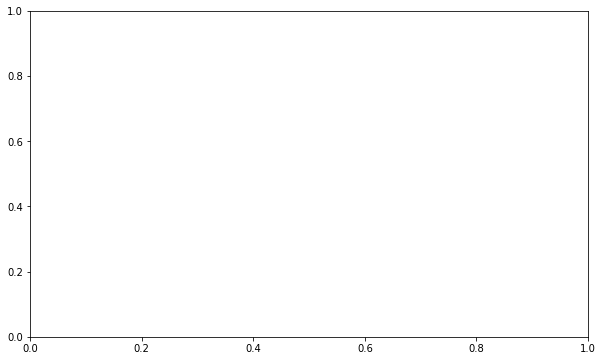

In [56]:
w = pd.merge(w, universe.loc[:,['itemcode', 'tracking_code']], left_index=True, right_on='itemcode', how='left')
w = w[['weights', 'tracking_code']].set_index('tracking_code')
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

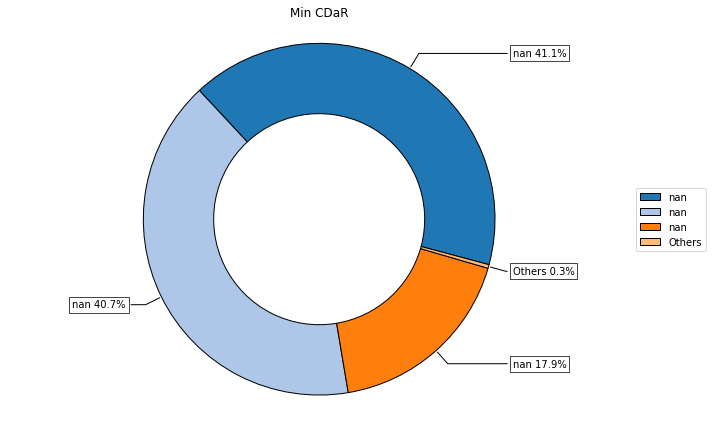

In [57]:
w = pd.merge(w, universe.loc[:,['itemcode', 'tracking_code']], left_index=True, right_on='itemcode', how='left')
w = w[['weights', 'tracking_code']].set_index('tracking_code')
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

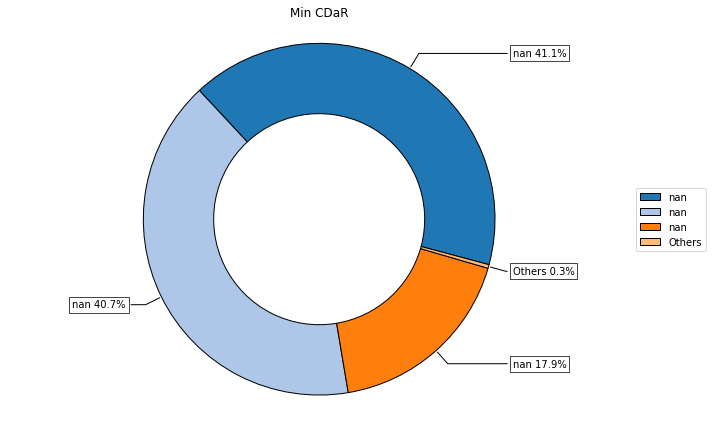

In [58]:
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

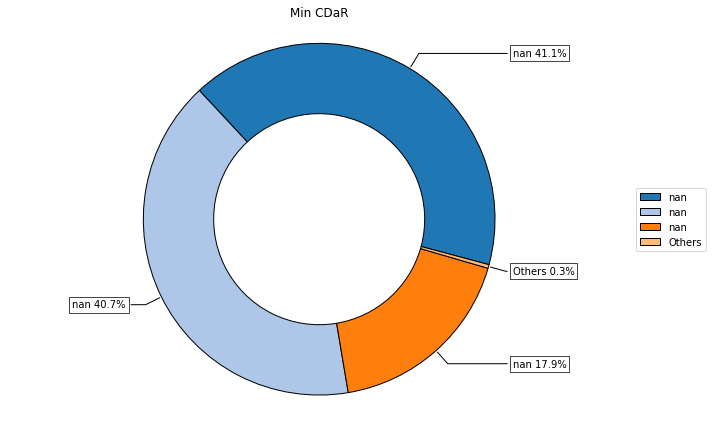

In [59]:
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

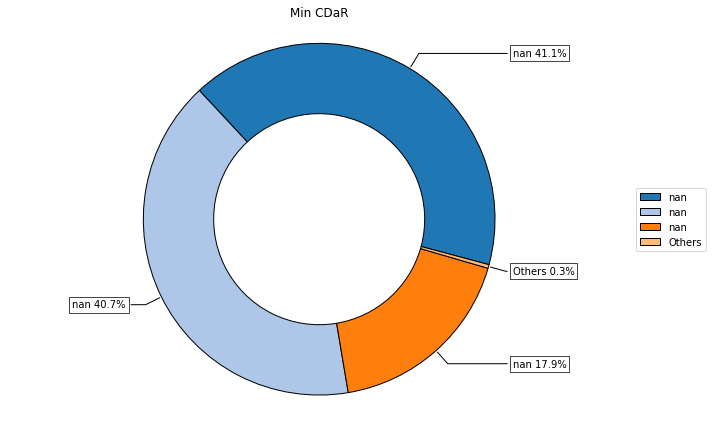

In [60]:
ax = plf.plot_pie(w=w, title='Min CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [61]:
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
5,False,Classes,Asset class,Equity,>=,0.40,NaN,NaN,NaN,NaN
6,False,Classes,Asset class,Equity,<=,0.60,NaN,NaN,NaN,NaN
7,False,Classes,Asset class,Fixed Income,<=,0.70,NaN,NaN,NaN,NaN
8,False,Classes,Asset class,Alternative,<=,0.25,NaN,NaN,NaN,4.0
9,False,Assets,NaN,A237370,>=,0.02,NaN,NaN,NaN,NaN
16,False,Classes,Strategy,Core,>=,NaN,Classes,Strategy,Satellite,4.0
18,False,All Assets,NaN,NaN,<=,0.24,NaN,NaN,NaN,NaN
19,False,Classes,DC risky asset,Y,<=,0.70,NaN,NaN,NaN,NaN
11,False,NaN,NaN,NaN,<=,0.70,NaN,NaN,NaN,NaN


In [62]:
A

NameError: name 'A' is not defined

In [63]:
A[:,-5]

NameError: name 'A' is not defined

In [64]:
B.T

NameError: name 'B' is not defined

In [65]:
asset_classes.iloc[-5]

NameError: name 'asset_classes' is not defined

In [66]:
asset_classes

NameError: name 'asset_classes' is not defined

In [67]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,A069500,A091160,A091170,A091180,A102110,A102780,A105190,A114260,A122260,A130730,...,A245710,A251350,A266370,A273130,A278540,A283580,A292150,A293180,A302190,A314250
0,7.680175e-14,2.624274e-03,1.868952e-12,6.509769e-14,7.794014e-14,4.918204e-14,9.776004e-14,4.549009e-13,7.906112e-13,1.785293e-01,...,3.820830e-14,3.354899e-14,5.626030e-14,2.926126e-13,2.901711e-13,9.769228e-14,4.226987e-04,8.482410e-14,8.704290e-13,4.461086e-14
1,3.659005e-10,1.310617e-08,2.784919e-10,1.682293e-10,3.733085e-10,4.416176e-10,3.605458e-10,1.015527e-08,5.751743e-01,1.448860e-07,...,3.056149e-10,8.504453e-10,4.049065e-10,3.717649e-01,3.671690e-10,3.413648e-02,3.754336e-10,3.796710e-10,1.126348e-08,1.892377e-02
2,1.183933e-11,5.974909e-10,9.633681e-12,6.075012e-12,1.205784e-11,1.366685e-11,1.168165e-11,6.926426e-11,1.402385e-01,5.915833e-09,...,1.099759e-11,3.137410e-11,1.300713e-11,7.616056e-01,1.190595e-11,6.343178e-02,1.232491e-11,1.223464e-11,2.684824e-10,3.472403e-02
3,2.302672e-10,3.344873e-09,2.009205e-10,1.348547e-10,2.333757e-10,2.352344e-10,2.259870e-10,2.410850e-09,7.490196e-09,6.747391e-09,...,2.411026e-10,1.275626e-09,2.658202e-10,4.189248e-01,2.254314e-10,9.299713e-02,2.572017e-10,2.343189e-10,4.407375e-09,5.112164e-02
4,1.244500e-11,8.741099e-10,1.084105e-11,7.103653e-12,1.265684e-11,1.388338e-11,1.223613e-11,1.302110e-10,1.469525e-10,1.283263e-10,...,1.274745e-11,7.156961e-11,1.442701e-11,5.807307e-10,1.240191e-11,1.511660e-01,1.351659e-11,1.279406e-11,2.560394e-10,5.780508e-02


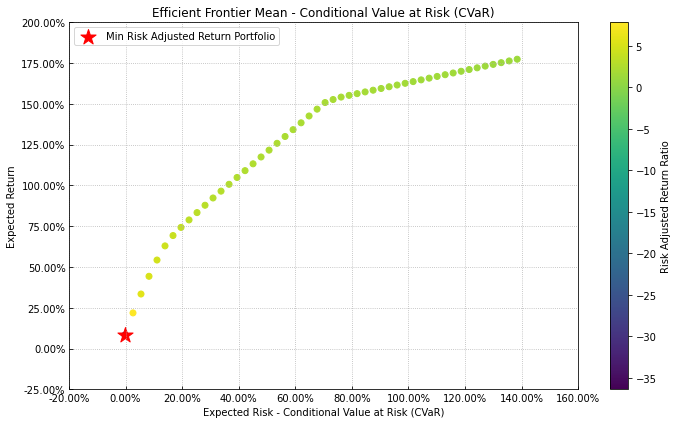

In [68]:
# Plotting the efficient frontier

label = 'Min Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

In [69]:
frontier

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A069500,7.680175e-14,3.659005e-10,1.183933e-11,2.302672e-10,1.244500e-11,1.552296e-10,6.994484e-11,2.486685e-11,6.633733e-11,7.795494e-11,...,2.086952e-12,4.098123e-12,2.275072e-12,8.777318e-12,1.550319e-11,1.499631e-11,9.640320e-12,2.274011e-11,1.287331e-11,5.213399e-11
A091160,2.624274e-03,1.310617e-08,5.974909e-10,3.344873e-09,8.741099e-10,4.497221e-02,4.943310e-02,2.109530e-02,5.182220e-10,4.597706e-09,...,6.420517e-01,6.818237e-01,7.215958e-01,7.613678e-01,8.011398e-01,8.409119e-01,8.806839e-01,9.204559e-01,9.602280e-01,1.000000e+00
A091170,1.868952e-12,2.784919e-10,9.633681e-12,2.009205e-10,1.084105e-11,1.322239e-10,4.463541e-11,1.619674e-11,4.373580e-11,5.219918e-11,...,1.193407e-12,2.396421e-12,1.309721e-12,4.981262e-12,8.788947e-12,8.524134e-12,5.478155e-12,1.321723e-11,7.328492e-12,3.028022e-11
A091180,6.509769e-14,1.682293e-10,6.075012e-12,1.348547e-10,7.103653e-12,8.543452e-11,5.579880e-11,2.036989e-11,5.027496e-11,6.025024e-11,...,1.501993e-12,2.972408e-12,1.658431e-12,6.277292e-12,1.100972e-11,1.124047e-11,6.853437e-12,1.631259e-11,9.144864e-12,3.765612e-11
A102110,7.794014e-14,3.733085e-10,1.205784e-11,2.333757e-10,1.265684e-11,1.578048e-10,7.032071e-11,2.499138e-11,6.673687e-11,7.843631e-11,...,2.097922e-12,4.118611e-12,2.286299e-12,8.824452e-12,1.558634e-11,1.503927e-11,9.692409e-12,2.286200e-11,1.294301e-11,5.240801e-11
A102780,4.918204e-14,4.416176e-10,1.366685e-11,2.352344e-10,1.388338e-11,1.773475e-10,9.621566e-11,3.496671e-11,8.643257e-11,1.033675e-10,...,2.615076e-12,5.057897e-12,2.835671e-12,1.107782e-11,1.948291e-11,1.860193e-11,1.212368e-11,2.826426e-11,1.618362e-11,6.466215e-11
A105190,9.776004e-14,3.605458e-10,1.168165e-11,2.259870e-10,1.223613e-11,1.525558e-10,6.924968e-11,2.462755e-11,6.566290e-11,7.713487e-11,...,2.073926e-12,4.071050e-12,2.261863e-12,8.719254e-12,1.539751e-11,1.490596e-11,9.572707e-12,2.258664e-11,1.278211e-11,5.180637e-11
A114260,4.549009e-13,1.015527e-08,6.926426e-11,2.410850e-09,1.302110e-10,1.333397e-09,2.935901e-10,1.062279e-10,2.872447e-10,3.388015e-10,...,2.162541e-12,4.436926e-12,2.313085e-12,9.482309e-12,1.661604e-11,8.205415e-12,1.037172e-11,2.527733e-11,1.346914e-11,5.527680e-11
A122260,7.906112e-13,5.751743e-01,1.402385e-01,7.490196e-09,1.469525e-10,1.244250e-09,2.301324e-10,8.474446e-11,2.255372e-10,2.684191e-10,...,2.076459e-12,4.241774e-12,2.224344e-12,9.048168e-12,1.587276e-11,8.666473e-12,9.903891e-12,2.411622e-11,1.292542e-11,5.302710e-11
A130730,1.785293e-01,1.448860e-07,5.915833e-09,6.747391e-09,1.283263e-10,1.134594e-09,2.184062e-10,8.007962e-11,2.138254e-10,2.547597e-10,...,2.054484e-12,4.193907e-12,2.201753e-12,8.941422e-12,1.568601e-11,8.745452e-12,9.789127e-12,2.383271e-11,1.278801e-11,5.246597e-11


In [70]:
frontier

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A069500,7.680175e-14,3.659005e-10,1.183933e-11,2.302672e-10,1.244500e-11,1.552296e-10,6.994484e-11,2.486685e-11,6.633733e-11,7.795494e-11,...,2.086952e-12,4.098123e-12,2.275072e-12,8.777318e-12,1.550319e-11,1.499631e-11,9.640320e-12,2.274011e-11,1.287331e-11,5.213399e-11
A091160,2.624274e-03,1.310617e-08,5.974909e-10,3.344873e-09,8.741099e-10,4.497221e-02,4.943310e-02,2.109530e-02,5.182220e-10,4.597706e-09,...,6.420517e-01,6.818237e-01,7.215958e-01,7.613678e-01,8.011398e-01,8.409119e-01,8.806839e-01,9.204559e-01,9.602280e-01,1.000000e+00
A091170,1.868952e-12,2.784919e-10,9.633681e-12,2.009205e-10,1.084105e-11,1.322239e-10,4.463541e-11,1.619674e-11,4.373580e-11,5.219918e-11,...,1.193407e-12,2.396421e-12,1.309721e-12,4.981262e-12,8.788947e-12,8.524134e-12,5.478155e-12,1.321723e-11,7.328492e-12,3.028022e-11
A091180,6.509769e-14,1.682293e-10,6.075012e-12,1.348547e-10,7.103653e-12,8.543452e-11,5.579880e-11,2.036989e-11,5.027496e-11,6.025024e-11,...,1.501993e-12,2.972408e-12,1.658431e-12,6.277292e-12,1.100972e-11,1.124047e-11,6.853437e-12,1.631259e-11,9.144864e-12,3.765612e-11
A102110,7.794014e-14,3.733085e-10,1.205784e-11,2.333757e-10,1.265684e-11,1.578048e-10,7.032071e-11,2.499138e-11,6.673687e-11,7.843631e-11,...,2.097922e-12,4.118611e-12,2.286299e-12,8.824452e-12,1.558634e-11,1.503927e-11,9.692409e-12,2.286200e-11,1.294301e-11,5.240801e-11
A102780,4.918204e-14,4.416176e-10,1.366685e-11,2.352344e-10,1.388338e-11,1.773475e-10,9.621566e-11,3.496671e-11,8.643257e-11,1.033675e-10,...,2.615076e-12,5.057897e-12,2.835671e-12,1.107782e-11,1.948291e-11,1.860193e-11,1.212368e-11,2.826426e-11,1.618362e-11,6.466215e-11
A105190,9.776004e-14,3.605458e-10,1.168165e-11,2.259870e-10,1.223613e-11,1.525558e-10,6.924968e-11,2.462755e-11,6.566290e-11,7.713487e-11,...,2.073926e-12,4.071050e-12,2.261863e-12,8.719254e-12,1.539751e-11,1.490596e-11,9.572707e-12,2.258664e-11,1.278211e-11,5.180637e-11
A114260,4.549009e-13,1.015527e-08,6.926426e-11,2.410850e-09,1.302110e-10,1.333397e-09,2.935901e-10,1.062279e-10,2.872447e-10,3.388015e-10,...,2.162541e-12,4.436926e-12,2.313085e-12,9.482309e-12,1.661604e-11,8.205415e-12,1.037172e-11,2.527733e-11,1.346914e-11,5.527680e-11
A122260,7.906112e-13,5.751743e-01,1.402385e-01,7.490196e-09,1.469525e-10,1.244250e-09,2.301324e-10,8.474446e-11,2.255372e-10,2.684191e-10,...,2.076459e-12,4.241774e-12,2.224344e-12,9.048168e-12,1.587276e-11,8.666473e-12,9.903891e-12,2.411622e-11,1.292542e-11,5.302710e-11
A130730,1.785293e-01,1.448860e-07,5.915833e-09,6.747391e-09,1.283263e-10,1.134594e-09,2.184062e-10,8.007962e-11,2.138254e-10,2.547597e-10,...,2.054484e-12,4.193907e-12,2.201753e-12,8.941422e-12,1.568601e-11,8.745452e-12,9.789127e-12,2.383271e-11,1.278801e-11,5.246597e-11


In [71]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\cvxpy\problems\problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [72]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
A069500,0.00%,0.00%,0.18%,0.00%,0.00%,0.00%,0.00%,0.00%,0.02%,0.02%,0.02%,0.03%,0.02%
A091160,0.06%,0.02%,0.00%,9.28%,5.68%,0.26%,0.26%,0.26%,0.20%,0.23%,0.22%,0.20%,0.22%
A091170,0.08%,0.12%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.05%,0.05%,0.04%,0.05%,0.04%
A091180,0.00%,0.07%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,0.01%,0.01%,0.01%,0.01%
A102110,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.02%,0.02%,0.02%,0.02%,0.02%
A102780,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.02%,0.02%,0.02%,0.02%,0.02%
A105190,0.06%,0.05%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.02%,0.02%,0.02%,0.02%,0.02%
A114260,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.43%,0.73%,1.04%,0.93%,0.93%
A122260,0.00%,0.00%,17.34%,0.00%,0.00%,0.00%,0.00%,0.00%,4.14%,1.97%,4.15%,2.13%,2.07%
A130730,15.60%,0.00%,20.81%,0.00%,0.00%,17.85%,18.49%,17.85%,32.99%,40.78%,35.90%,41.70%,40.20%


In [62]:
import riskfolio.ConstraintsFunctions as cf

asset_classes = {'Assets': ['FB', 'GOOGL', 'NTFX', 'BAC', 'WFC', 'TLT', 'SHV'],
                 'Class 1': ['Equity', 'Equity', 'Equity', 'Equity', 'Equity',
                             'Fixed Income', 'Fixed Income'],
                 'Class 2': ['Technology', 'Technology', 'Technology',
                             'Financial', 'Financial', 'Treasury', 'Treasury'],}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False, False, False],
               'Type': ['Classes', 'Classes', 'Assets', 'Assets', 'Classes',
                        'All Assets', 'Each asset in a class'],
               'Set': ['Class 1', 'Class 1', '', '', 'Class 2', '', 'Class 1'],
               'Position': ['Equity', 'Fixed Income', 'BAC', 'WFC', 'Financial',
                            '', 'Equity'],
               'Sign': ['<=', '<=', '<=', '<=', '>=', '>=', '>='],
               'Weight': [0.6, 0.5, 0.1, '', '', 0.02, ''],
               'Type Relative': ['', '', '', 'Assets', 'Classes', '', 'Assets'],
               'Relative Set': ['', '', '', '', 'Class 1', '', ''],
               'Relative': ['', '', '', 'FB', 'Fixed Income', '', 'TLT'],
               'Factor': ['', '', '', 1.2, 0.5, '', 0.4]}

constraints = pd.DataFrame(constraints)

display(asset_classes)
display(constraints)

,Assets,Class 1,Class 2
3,BAC,Equity,Financial
0,FB,Equity,Technology
1,GOOGL,Equity,Technology
2,NTFX,Equity,Technology
6,SHV,Fixed Income,Treasury
5,TLT,Fixed Income,Treasury
4,WFC,Equity,Financial


,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,Classes,Class 1,Equity,<=,0.6,,,,
1,False,Classes,Class 1,Fixed Income,<=,0.5,,,,
2,False,Assets,,BAC,<=,0.1,,,,
3,False,Assets,,WFC,<=,,Assets,,FB,1.2
4,False,Classes,Class 2,Financial,>=,,Classes,Class 1,Fixed Income,0.5
5,False,All Assets,,,>=,0.02,,,,
6,False,Each asset in a class,Class 1,Equity,>=,,Assets,,TLT,0.4


In [ ]:
def get_asset_classes(instruments):
    '''
    Riskfolio 패키지에서 제약조건을 걸 때 필요한 
    데이터 프레임 인스턴스 asset_classes를 instruments로부터 만들어
    반환한다.

    참조: https://riskfolio-lib.readthedocs.io/en/latest/constraints.html

    Parameters:
    instruments: pd.DataFrame
        - 투자 유니버스 중 거래가능한 종목들의 집합


    Returns:
    asset_classes: pd.DataFrame
        - ConstraintsFunctions.assets_constraints의 두 번째 파라미터 값
    '''
    asset_classes = instruments.rename(
        columns={
            'itemcode': 'Assets',
            'asset_class': 'Asset class',
            'dc_risky_asset': 'DC risky asset',
            'issuer': 'Issuer',
            'strategy': 'Strategy'
        })
    
    return asset_classes

In [61]:
import riskfolio.ConstraintsFunctions as cf

asset_classes = {'Assets': ['JCI','TGT','CMCSA','CPB','MO','APA','MMC','JPM',
                            'ZION','PSA','BAX','BMY','LUV','PCAR','TXT','TMO',
                            'DE','MSFT','HPQ','SEE','VZ','CNP','NI','T','BA'], 
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy','Financials',
                              'Financials','Financials','Financials',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Industrials','Health care','Industrials',
                              'Information Technology','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities','Telecommunications Services','Financials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False],
               'Type': ['All Assets', 'Classes', 'Classes', 'Classes',
                        'Classes'],
               'Set': ['', 'Industry', 'Industry', 'Industry', 'Industry'],
               'Position': ['', 'Financials', 'Utilities', 'Industrials',
                            'Consumer Discretionary'],
               'Sign': ['<=', '<=', '<=', '<=', '<='],
               'Weight': [0.10, 0.2, 0.2, 0.2, 0.2],
               'Type Relative': ['', '', '', '', ''],
               'Relative Set': ['', '', '', '', ''],
               'Relative': ['', '', '', '', ''],
               'Factor': ['', '', '', '', '']}

constraints = pd.DataFrame(constraints)

display(asset_classes)
display(constraints)

,Assets,Industry
5,APA,Energy
24,BA,Financials
10,BAX,Health Care
11,BMY,Health Care
2,CMCSA,Consumer Discretionary
21,CNP,Utilities
3,CPB,Consumer Staples
16,DE,Industrials
18,HPQ,Information Technology
0,JCI,Consumer Discretionary


,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,0.1,,,,
1,False,Classes,Industry,Financials,<=,0.2,,,,
2,False,Classes,Industry,Utilities,<=,0.2,,,,
3,False,Classes,Industry,Industrials,<=,0.2,,,,
4,False,Classes,Industry,Consumer Discretionary,<=,0.2,,,,


In [74]:
constraints

,risk_profile,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,2,False,Classes,Asset class,Equity,>=,0.01,NaN,NaN,NaN,NaN
1,2,False,Classes,Asset class,Equity,<=,0.03,NaN,NaN,NaN,NaN
2,2,False,Classes,Asset class,Alternative,<=,0.03,NaN,NaN,NaN,NaN
3,3,False,Classes,Asset class,Equity,>=,0.30,NaN,NaN,NaN,NaN
4,3,False,Classes,Asset class,Equity,<=,0.50,NaN,NaN,NaN,NaN
5,3,False,Classes,Asset class,Fixed Income,<=,0.70,NaN,NaN,NaN,NaN
6,3,False,Classes,Asset class,Alternative,<=,0.10,NaN,NaN,NaN,NaN
7,4,False,Classes,Asset class,Equity,>=,0.40,NaN,NaN,NaN,NaN
8,4,False,Classes,Asset class,Equity,<=,0.70,NaN,NaN,NaN,NaN
9,4,False,Classes,Asset class,Fixed Income,<=,0.50,NaN,NaN,NaN,NaN


In [70]:
asset_classes.columns

Index(['itemcode', 'asset_class', 'dc_risky_asset', 'issuer', 'strategy'], dtype='object')

In [63]:
np.__version__

'1.20.1'